<a href="https://colab.research.google.com/github/Edwin2711/DetectionAlgorithm/blob/main/prototype1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

import cv2
import pathlib
from PIL import Image
from io import open
import torch.functional as F
from torchvision.models import squeezenet1_1

import matplotlib.pyplot as plt
import time

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#Transforms

# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),
    transforms.ToTensor(),#0-255 to 0-1, numpy to tensors
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [4]:
!unzip /content/tanks.zip

Archive:  /content/tanks.zip
   creating: tanks/pred/
  inflating: tanks/pred/c1.jpg       
  inflating: tanks/pred/c5.jpg       
  inflating: tanks/pred/c6.jpg       
  inflating: tanks/pred/s2.jpg       
  inflating: tanks/pred/s5.jpg       
  inflating: tanks/pred/s6.jpg       
   creating: tanks/test/
   creating: tanks/test/composite/
  inflating: tanks/test/composite/c1.jpg  
   creating: tanks/test/steel/
  inflating: tanks/test/steel/s1.jpg  
   creating: tanks/train/
   creating: tanks/train/composite/
  inflating: tanks/train/composite/c1.jpg  
  inflating: tanks/train/composite/c10.jpg  
  inflating: tanks/train/composite/c2.jpg  
  inflating: tanks/train/composite/c3.jpg  
  inflating: tanks/train/composite/c4.jpg  
  inflating: tanks/train/composite/c5.jpg  
  inflating: tanks/train/composite/c6.jpg  
  inflating: tanks/train/composite/c7.jpg  
  inflating: tanks/train/composite/c8.jpg  
  inflating: tanks/train/composite/c9.jpg  
   creating: tanks/train/steel/
  inflatin

In [4]:
#Dataloader

#train and valid directory
train_path='tanks/train'
valid_path='tanks/valid'

train_data = torchvision.datasets.ImageFolder(train_path,transform=train_transform)
train_loader=DataLoader(
    train_data,
    batch_size=64, shuffle=True
)

valid_data = torchvision.datasets.ImageFolder(valid_path,transform=valid_transform)
valid_loader=DataLoader(
    valid_data,
    batch_size=32, shuffle=False
)
# Report split sizes
print('Training set has {} instances'.format(len(train_data)))
print('Validation set has {} instances'.format(len(valid_data)))

Training set has 20 instances
Validation set has 12 instances


In [5]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['composite', 'steel']


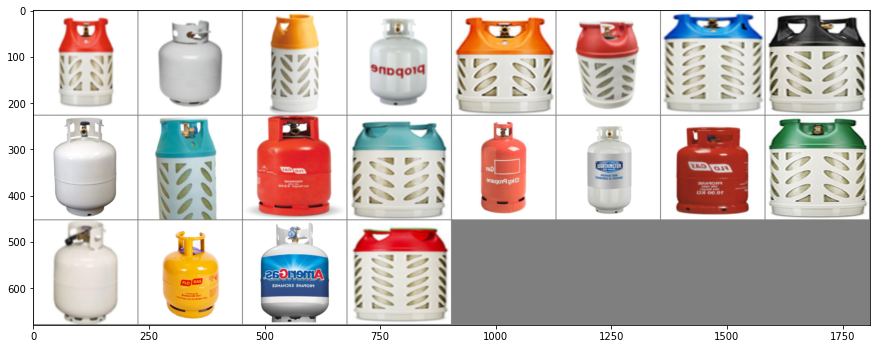

In [6]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(train_loader))

# Create a grid from the images and show them
plt.figure(figsize=(15, 10))
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)

#print('  '.join(classes[labels[j]] for j in range(len(train_data))))

In [7]:
#CNN Network

class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (32,3,224,224)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (32,12,224,224)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()

        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (32,12,112,112)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (32,20,112,112)
        self.bn2=nn.BatchNorm2d(num_features=20)
        self.relu2=nn.ReLU()
        

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (32,32,112,112)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        
        
        self.fc=nn.Linear(in_features= 112 * 112 * 32,out_features=num_classes)

        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        output=output.view(-1,32*112*112)
            
            
        output=self.fc(output)
            
        return output

In [8]:
model=ConvNet(num_classes=2).to(device)

In [9]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function = torch.nn.CrossEntropyLoss()

In [10]:
num_epochs=10
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
valid_count=len(glob.glob(valid_path+'/**/*.jpg'))
print(train_count,valid_count)

20 12


In [11]:
#Model training and saving best model

best_accuracy=0.0
# lists to keep track of losses and accuracies
train_loss_List, valid_loss_List = [], []
train_acc_List, valid_acc_List = [], []
for epoch in range(num_epochs):
  
  #Evaluation and training on training dataset
  model.train()
  train_accuracy=0.0
  train_loss=0.0
  
  for i, (images,labels) in enumerate(train_loader):
      if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
          
      optimizer.zero_grad()

      # Make predictions for this batch
      outputs=model(images)
      # Compute the loss and its gradients
      loss=loss_function(outputs,labels)
      loss.backward()
      # Adjust learning weights
      optimizer.step()
      
      
      train_loss+= loss.cpu().data*images.size(0)
      _,prediction=torch.max(outputs.data,1)
      
      train_accuracy+=int(torch.sum(prediction==labels.data))
      
  train_accuracy=train_accuracy/train_count
  train_loss=train_loss/train_count

  
  # Evaluation on testing dataset
  model.eval()
  
  validation_accuracy=0.0
  validation_loss = 0.0

  for i, (images,labels) in enumerate(valid_loader):
      if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
          
      outputs=model(images)
      loss=loss_function(outputs,labels)
      validation_loss+= loss.cpu().data*images.size(0)
      _,prediction=torch.max(outputs.data,1)
      validation_accuracy+=int(torch.sum(prediction==labels.data))
  
  validation_accuracy=validation_accuracy/valid_count
  validation_loss=validation_loss/valid_count
  
  
  print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Valid Loss: '+str(validation_loss)+' Valid Accuracy: '+str(validation_accuracy))
  train_loss_List.append(train_loss)
  valid_loss_List.append(validation_loss)
  train_acc_List.append(train_accuracy)
  valid_acc_List.append(validation_accuracy)
  #Save the best model
  if validation_accuracy>best_accuracy:
      torch.save(model.state_dict(),'best_checkpoint.model')
      best_accuracy=validation_accuracy

Epoch: 0 Train Loss: tensor(0.7518) Train Accuracy: 0.4 Valid Loss: tensor(4.2977) Valid Accuracy: 0.5
Epoch: 1 Train Loss: tensor(27.8604) Train Accuracy: 0.75 Valid Loss: tensor(0.7628) Valid Accuracy: 0.5833333333333334
Epoch: 2 Train Loss: tensor(3.7675) Train Accuracy: 0.85 Valid Loss: tensor(4.3602) Valid Accuracy: 0.5
Epoch: 3 Train Loss: tensor(3.1809) Train Accuracy: 0.9 Valid Loss: tensor(6.0836) Valid Accuracy: 0.5
Epoch: 4 Train Loss: tensor(5.1617) Train Accuracy: 0.8 Valid Loss: tensor(4.0183) Valid Accuracy: 0.5
Epoch: 5 Train Loss: tensor(0.7847) Train Accuracy: 0.95 Valid Loss: tensor(1.9231) Valid Accuracy: 0.4166666666666667
Epoch: 6 Train Loss: tensor(0.) Train Accuracy: 1.0 Valid Loss: tensor(1.5529) Valid Accuracy: 0.5833333333333334
Epoch: 7 Train Loss: tensor(0.) Train Accuracy: 1.0 Valid Loss: tensor(2.6055) Valid Accuracy: 0.75
Epoch: 8 Train Loss: tensor(0.) Train Accuracy: 1.0 Valid Loss: tensor(3.9367) Valid Accuracy: 0.75
Epoch: 9 Train Loss: tensor(0.) Tr

In [12]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='dotted', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='dotted', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

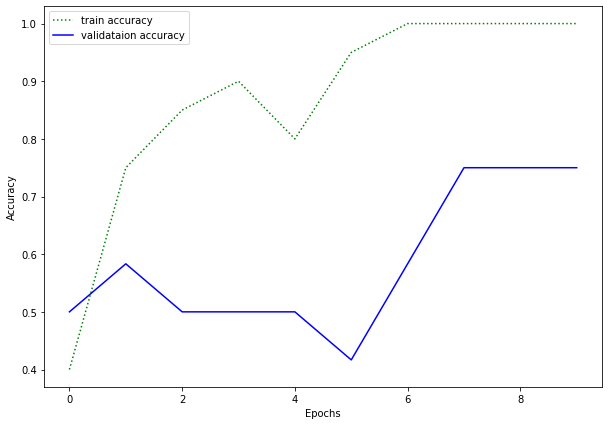

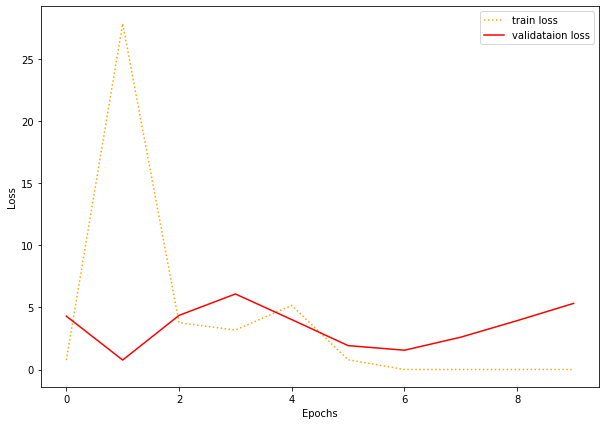

In [13]:

save_plots(train_acc_List, valid_acc_List, train_loss_List, valid_loss_List)


In [17]:
pred_path='tanks/pred'
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [18]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred
    

In [28]:
from google.colab.patches import cv2_imshow
images_path=glob.glob(pred_path+'/*.jpg')
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)
    print(i)
pred_dict

tanks/pred/c6.jpg
tanks/pred/s2.jpg
tanks/pred/c5.jpg
tanks/pred/s5.jpg
tanks/pred/s6.jpg
tanks/pred/c1.jpg


{'c6.jpg': 'composite',
 's2.jpg': 'steel',
 'c5.jpg': 'composite',
 's5.jpg': 'steel',
 's6.jpg': 'steel',
 'c1.jpg': 'composite'}